In [29]:
import numpy
import math
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import wilcoxon
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import tensorflow as tf

In [30]:
#Read in day wise AQI and calculate mean monthly AQI values
data = pandas.read_csv('prominent.csv')
cities = ['Bengaluru']
month=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

In [31]:
for city in cities:
    temp = data.loc[data['City'] == city]
    if(not temp.empty):
        train = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        test = pandas.DataFrame(columns=['Year','Month','Mean','Pollutant'])
        for i in range(2016,2020):
            for j in range(1,13):
                count=0
                aqisum=0
                prominent = {}
                for k in range(1,32):
                    date = str(i)+'-'+str("%02d" % j)+'-'+str("%02d" % k)
                    record = temp.loc[temp['Date'] == date]
                    if(not record.empty):
                        if(not math.isnan(record['AQI'])):
                            aqisum = aqisum + record.iloc[0]['AQI']
                            count = count + 1
                            pollutants = record['AQI_label'].to_string()
                            pollutants = pollutants.replace('\'','')
                            pollutants = pollutants.split('(', 1)[-1]
                            pollutants = pollutants.split(')', 1)[0]
                            for pollutant in pollutants.split(','):
                                if(str(pollutant) in prominent):
                                    prominent[str(pollutant)]=prominent[pollutant]+1
                                
                                elif(str(pollutant) != ''):
                                    prominent[str(pollutant)]=0
                                
                            
                        
                    
                
                if(prominent):
                    mark = max(prominent, key=prominent.get)

                else:
                    mark = ''
                
                if(count <= 15):
                    mean=float('NaN')
                
                else:
                    mean=float(aqisum/count)
                
                if(i == 2019):
                    test = test.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
                else:
                    train = train.append({'Year': i,'Month': month[j-1], 'Mean': mean, 'Pollutant':mark},ignore_index=True)
                
            
        
    


<AxesSubplot:>

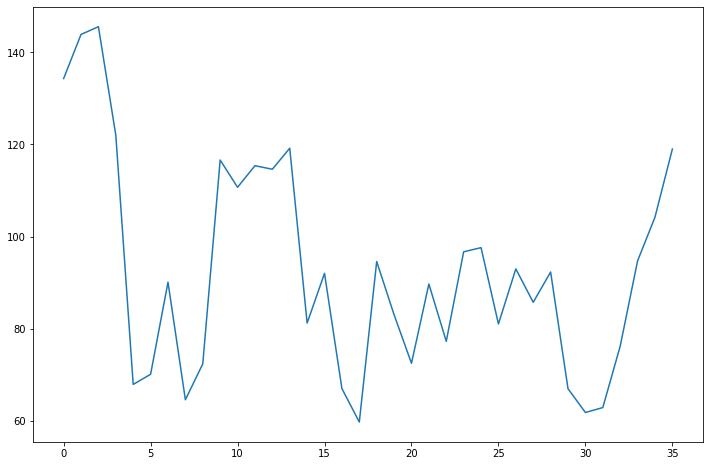

In [32]:
#Interpolate AQI data over 2016, 2017 and 2018
train['Mean'] = train['Mean'].interpolate()
test['Mean'] = test['Mean'].interpolate()
train['Mean'].plot(figsize=(12,8))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AQI')

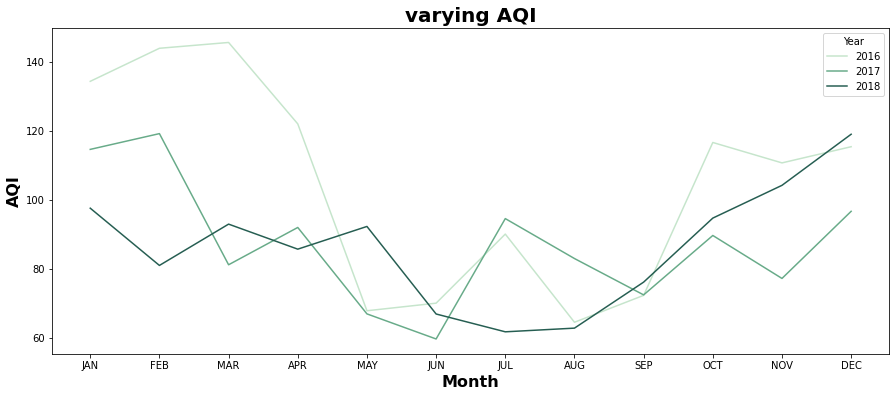

In [33]:
#Plot the seasonal plot for AQI across 2016, 2017 and 2018
variable = 'salinitySurface'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 3)
sns.lineplot(train['Month'], train['Mean'], hue=train['Year'], palette=palette)
ax.set_title('varying AQI', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'AQI')

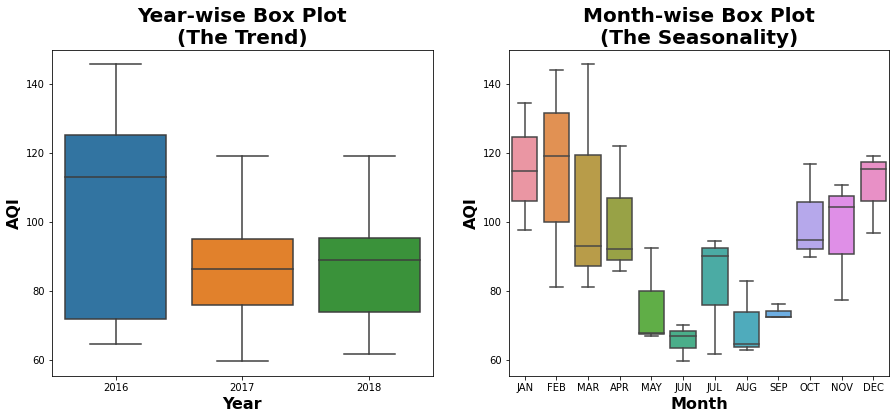

In [34]:
#Plot the year-wise and Month-wise box plot to visualize trend and seasonality
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(train['Year'], train['Mean'], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(train['Month'], train['Mean'], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('AQI', fontsize = 16, fontdict=dict(weight='bold'))

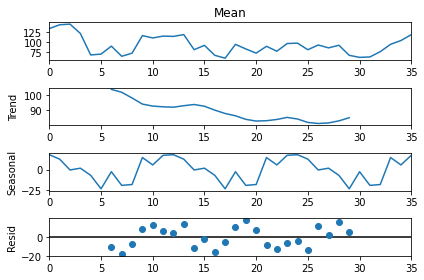

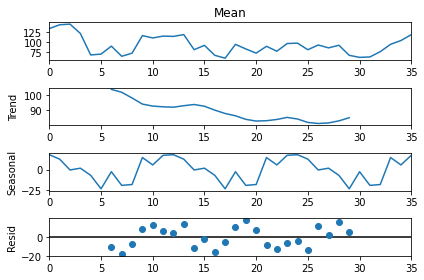

In [35]:
#Decompose time series data into trend, seasonality and residual
res = seasonal_decompose(train['Mean'], model='additive', period=12)
res.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

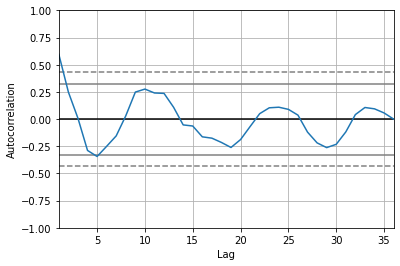

In [36]:
#Check if data is stationary based on auto correlation and ADF statistic
pandas.plotting.autocorrelation_plot(train['Mean'])

In [37]:
signi = adfuller(train['Mean'])
print('ADF Statistic: %f' % signi[0])
print('p-value: %f' % signi[1])
print('Critical Values:')
for key, value in signi[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.703053
p-value: 0.000083
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


In [38]:
train
li_val = list(train['Mean'])

In [39]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		end_ix = i + n_features
		if end_ix > len(timeseries_data)-1:
			break
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return numpy.array(X), numpy.array(y)

In [40]:
timeseries_data = li_val
n_steps = 5
X, y = prepare_data(timeseries_data, n_steps)

In [41]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [42]:
numpy.random.seed(80)
tf.random.set_seed(80)
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=1400, verbose=1)

Epoch 1/1400
1/1 [==============================] - 0s 1ms/step - loss: 8056.5503
Epoch 2/1400
1/1 [==============================] - 0s 1ms/step - loss: 7377.6006
Epoch 3/1400
1/1 [==============================] - 0s 1ms/step - loss: 6761.0132
Epoch 4/1400
1/1 [==============================] - 0s 5ms/step - loss: 6173.6821
Epoch 5/1400
1/1 [==============================] - 0s 1ms/step - loss: 5586.6006
Epoch 6/1400
1/1 [==============================] - 0s 1ms/step - loss: 4972.6851
Epoch 7/1400
1/1 [==============================] - 0s 1ms/step - loss: 4312.1567
Epoch 8/1400
1/1 [==============================] - 0s 1ms/step - loss: 3594.9436
Epoch 9/1400
1/1 [==============================] - 0s 1ms/step - loss: 2837.0161
Epoch 10/1400
1/1 [==============================] - 0s 1ms/step - loss: 2065.2231
Epoch 11/1400
1/1 [==============================] - 0s 1ms/step - loss: 1331.7474
Epoch 12/1400
1/1 [==============================] - 0s 4ms/step - loss: 852.6575
Epoch 13/1400


In [43]:
x_input = numpy.array([
    62.83870967741935,
 76.16666666666667,
 94.70967741935483,
 104.2,
 119.0])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<24):
    
    if(len(temp_input)>5):
        x_input=numpy.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    



[120.239746]
1 day input [ 76.16666667  94.70967742 104.2        119.         120.23974609]
1 day output [[121.26463]]
2 day input [ 94.70967742 104.2        119.         120.23974609 121.26463318]
2 day output [[131.13524]]
3 day input [104.2        119.         120.23974609 121.26463318 131.13523865]
3 day output [[121.35819]]
4 day input [119.         120.23974609 121.26463318 131.13523865 121.35819244]
4 day output [[110.00921]]
5 day input [120.239746 121.26463  131.13524  121.35819  110.00921 ]
5 day output [[81.8601]]
6 day input [121.26463 131.13524 121.35819 110.00921  81.8601 ]
6 day output [[69.08646]]
7 day input [131.13524 121.35819 110.00921  81.8601   69.08646]
7 day output [[65.27321]]
8 day input [121.35819 110.00921  81.8601   69.08646  65.27321]
8 day output [[62.158688]]
9 day input [110.00921   81.8601    69.08646   65.27321   62.158688]
9 day output [[93.96995]]
10 day input [81.8601   69.08646  65.27321  62.158688 93.96995 ]
10 day output [[90.13805]]
11 day inpu

In [44]:
lst_2019 = [x for x in lst_output[0:12]]

from sklearn.metrics import r2_score
print(r2_score(list(test['Mean']), lst_2019))

0.8538185262152728


In [45]:
a = list(test['Mean'])

In [46]:
lst_2020 = [x for x in lst_output[12:24]]

In [47]:
import pandas as pd
list_avg_AQI_2020_bangalore = []
df_cityday = pd.read_csv('prominent.csv')
df_bangalore = df_cityday[df_cityday['City']=='Bengaluru']

In [48]:
df_bangalore_2020_jan = df_bangalore[(df_bangalore['Date']>'2020-01-01') & (df_bangalore['Date']<'2020-01-31')]


df_bangalore_2020_jan = df_bangalore_2020_jan[df_bangalore_2020_jan['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_jan['AQI'].mean())

df_bangalore_2020_feb = df_bangalore[(df_bangalore['Date']>'2020-02-01') & (df_bangalore['Date']<'2020-02-28')]


df_bangalore_2020_feb = df_bangalore_2020_feb[df_bangalore_2020_feb['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_feb['AQI'].mean())


df_bangalore_2020_mar = df_bangalore[(df_bangalore['Date']>'2020-03-01') & (df_bangalore['Date']<'2020-03-31')]


df_bangalore_2020_mar = df_bangalore_2020_mar[df_bangalore_2020_mar['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_mar['AQI'].mean())

df_bangalore_2020_apr = df_bangalore[(df_bangalore['Date']>'2020-04-01') & (df_bangalore['Date']<'2020-04-30')]


df_bangalore_2020_apr = df_bangalore_2020_apr[df_bangalore_2020_apr['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_apr['AQI'].mean())

df_bangalore_2020_may = df_bangalore[(df_bangalore['Date']>'2020-05-01') & (df_bangalore['Date']<'2020-05-31')]


df_bangalore_2020_may = df_bangalore_2020_may[df_bangalore_2020_may['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_may['AQI'].mean())

df_bangalore_2020_jun = df_bangalore[(df_bangalore['Date']>'2020-06-01') & (df_bangalore['Date']<'2020-06-30')]


df_bangalore_2020_jun = df_bangalore_2020_jun[df_bangalore_2020_jun['AQI'].notna()]


list_avg_AQI_2020_bangalore.append(df_bangalore_2020_jun['AQI'].mean())


In [49]:
list_dates = ['JAN','FEB','MAR','APR','MAY','JUN']
#lst_2019_graph = [x for x in lst_output[0:6]]
lst_2020_graph = [x for x in lst_2020[0:6]]
lst_2020_original = [x for x in list_avg_AQI_2020_bangalore[0:6]]

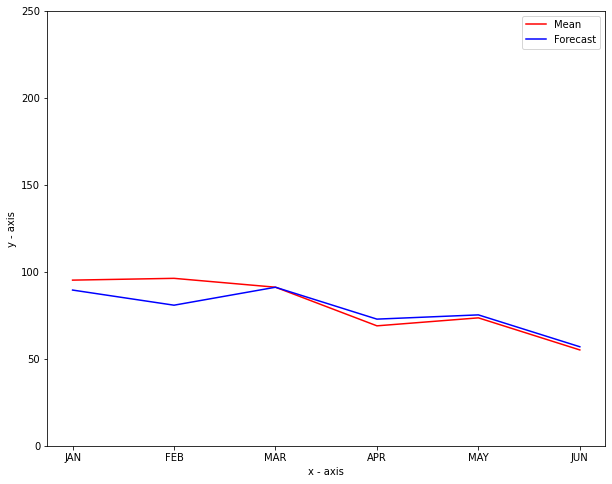

In [53]:
import matplotlib.pyplot as plt 

plt.figure(figsize = (10,8))


plt.plot(list_dates, lst_2020_original ,  color='red', label='Mean') 
plt.plot(list_dates, lst_2020_graph,  color='blue', label='Forecast') 
plt.ylim(0,250)
plt.xlabel('x - axis')  
plt.ylabel('y - axis')  
plt.legend() 
plt.show() 

In [51]:
stat, p = wilcoxon(lst_2020_graph, lst_2020_original)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9.000, p=0.844
